In [2]:
import sys
!{sys.executable} -m pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [3]:
import os
import numpy as np
import pandas as pd
import re
import string
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from torch.optim import NAdam
from collections import defaultdict

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Initialize tqdm for pandas
tqdm.pandas()

# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Configuration
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Twitter preprocessing constants
EMOTICON_SET = {
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-(', ':-(', ':(', ':-c', ':c', ':-<', ':<', ':-[', ':[',
    ':-||', '>:[', ':{', ':@', ":'-(", ":'(", 'D:<', 'D:', 'D8', 'D;', 'D=',
    'DX', 'v.v', "D-':", ">_>", "^_^", "-_-", "o_o", "O_O", "x_x", "X_X",
    "<3", "</3", "\\o/", "*\\0/*", "♥", "❌", "✅", "🔥", "😊", "😠", "😡", "🤔"
}

def preprocess_tweet(text):
    """Paper-aligned Twitter text preprocessing"""
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text, flags=re.MULTILINE)

    # Replace user mentions
    text = re.sub(r'@\w+', '<USER>', text)

    # Tokenize with Twitter-aware rules
    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False)
    tokens = tokenizer.tokenize(text)

    processed = []
    for token in tokens:
        # Preserve emojis/emoticons
        if token in EMOTICON_SET:
            processed.append(token)
        # Process hashtags
        elif token.startswith('#'):
            cleaned = token[1:].replace('_', ' ')
            processed.extend(cleaned.split())
        # Remove non-emoji punctuation
        elif token in string.punctuation:
            continue
        # Basic cleaning
        else:
            cleaned = token.translate(str.maketrans('', '', string.punctuation))
            if cleaned and cleaned not in stop_words:
                processed.append(cleaned)

    return ' '.join(processed)

def load_data():
    """Load and preprocess dataset with sampling"""
    csv_path = "/content/drive/MyDrive/Colab Notebooks/data.csv"
    df = pd.read_csv(
        csv_path,
        encoding='latin-1',
        header=None,
        usecols=[0, 5],
        names=['sentiment', 'text']
    )

    #df =  pd.read_csv(csv_path, encoding="ISO-8859-1", header=None , names=['label', 'ids', 'data', 'flag' , 'user','sentence'])
    df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

    # Reduced dataset sampling (keep this portion)
    fraction = 0.3
    negative = df[df['sentiment'] == 0].sample(frac=fraction, random_state=RANDOM_SEED)
    positive = df[df['sentiment'] == 1].sample(frac=fraction, random_state=RANDOM_SEED)
    df = pd.concat([negative, positive]).reset_index(drop=True)

    print("Preprocessing text...")
    df['text'] = df['text'].progress_apply(preprocess_tweet)

    return train_test_split(
        df, test_size=0.2, stratify=df['sentiment'], random_state=RANDOM_SEED)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class HybridModel(nn.Module):
    def __init__(self, rnn_type, hidden_dim):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")

        # RNN configuration from paper
        if rnn_type == 'BiLSTM':
            self.rnn = nn.LSTM(self.roberta.config.hidden_size, hidden_dim,
                             bidirectional=True, batch_first=True)
            hidden_dim *= 2
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(self.roberta.config.hidden_size, hidden_dim,
                             batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(self.roberta.config.hidden_size, hidden_dim,
                            batch_first=True)

        # Paper-specified classifier
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, 2)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        features = self.roberta(input_ids, attention_mask).last_hidden_state
        rnn_out, _ = self.rnn(features)
        x = rnn_out[:, -1, :]  # Last timestep
        x = self.relu(self.fc1(x))
        return self.fc2(x)

def train_model(model, train_loader, val_loader, epochs=10):  # Increased epochs
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    optimizer = NAdam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0, 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        # Calculate metrics
        train_loss_val = train_loss / len(train_loader)
        train_acc_val = train_correct / len(train_loader.dataset)
        val_loss_val = val_loss / len(val_loader)
        val_acc_val = val_correct / len(val_loader.dataset)

        history['train_loss'].append(train_loss_val)
        history['train_acc'].append(train_acc_val)
        history['val_loss'].append(val_loss_val)
        history['val_acc'].append(val_acc_val)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss_val:.4f} | Acc: {train_acc_val:.4f}")
        print(f"Val Loss:   {val_loss_val:.4f} | Acc: {val_acc_val:.4f}")

    return history

def ensemble_predict(models, loader, method='average'):
    all_probs = defaultdict(list)
    true_labels = []

    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            true_labels.extend(batch['labels'].numpy())

            for name, model in models.items():
                model.eval()
                outputs = model(**inputs)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                all_probs[name].append(probs)

    # Paper's ensemble strategy
    avg_probs = np.zeros((len(true_labels), 2))
    majority = np.zeros(len(true_labels))

    for name in models:
        model_probs = np.concatenate(all_probs[name], axis=0)
        avg_probs += model_probs
        majority += model_probs.argmax(axis=1)

    avg_probs /= len(models)
    majority = (majority >= len(models)//2 + 1).astype(int)

    if method == 'average':
        return true_labels, avg_probs.argmax(axis=1)
    elif method == 'majority':
        return true_labels, majority

if __name__ == "__main__":
    # Load and prepare data
    train_df, test_df = load_data()
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

    # Create datasets
    train_dataset = SentimentDataset(train_df['text'].tolist(),
                                    train_df['sentiment'].tolist(),
                                    tokenizer)
    test_dataset = SentimentDataset(test_df['text'].tolist(),
                                   test_df['sentiment'].tolist(),
                                   tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize models
    models = {
        'RoBERTa-LSTM': HybridModel('LSTM', 256),
        'RoBERTa-BiLSTM': HybridModel('BiLSTM', 128),
        'RoBERTa-GRU': HybridModel('GRU', 256)
    }

    # Train individual models
    for name, model in models.items():
        print(f"\n{'='*40}\nTraining {name}\n{'='*40}")
        _ = train_model(model, train_loader, test_loader, epochs=3)  # Paper-like training

    # Ensemble evaluation
    print("\n\nEnsemble Evaluation:")

    # Average Ensemble
    y_true, y_pred = ensemble_predict(models, test_loader, 'average')
    print("\nAverage Ensemble:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # Majority Voting
    y_true, y_pred = ensemble_predict(models, test_loader, 'majority')
    print("\nMajority Voting:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing text...


100%|██████████| 480000/480000 [01:16<00:00, 6252.75it/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training RoBERTa-LSTM


Epoch 1/3: 100%|██████████| 12000/12000 [1:11:09<00:00,  2.81it/s]



Epoch 1 Summary:
Train Loss: 0.4405 | Acc: 0.7941
Val Loss:   0.4186 | Acc: 0.8108


Epoch 2/3: 100%|██████████| 12000/12000 [1:11:02<00:00,  2.82it/s]



Epoch 2 Summary:
Train Loss: 0.3930 | Acc: 0.8217
Val Loss:   0.4072 | Acc: 0.8149


Epoch 3/3: 100%|██████████| 12000/12000 [1:11:09<00:00,  2.81it/s]



Epoch 3 Summary:
Train Loss: 0.3585 | Acc: 0.8404
Val Loss:   0.4255 | Acc: 0.8159

Training RoBERTa-BiLSTM


Epoch 1/3: 100%|██████████| 12000/12000 [1:10:50<00:00,  2.82it/s]



Epoch 1 Summary:
Train Loss: 0.4410 | Acc: 0.7941
Val Loss:   0.4176 | Acc: 0.8123


Epoch 2/3: 100%|██████████| 12000/12000 [1:10:48<00:00,  2.82it/s]



Epoch 2 Summary:
Train Loss: 0.3935 | Acc: 0.8208
Val Loss:   0.4088 | Acc: 0.8152


Epoch 3/3: 100%|██████████| 12000/12000 [1:10:55<00:00,  2.82it/s]



Epoch 3 Summary:
Train Loss: 0.3599 | Acc: 0.8400
Val Loss:   0.4321 | Acc: 0.8156

Training RoBERTa-GRU


Epoch 1/3: 100%|██████████| 12000/12000 [1:10:56<00:00,  2.82it/s]



Epoch 1 Summary:
Train Loss: 0.4384 | Acc: 0.7957
Val Loss:   0.4362 | Acc: 0.8111


Epoch 2/3: 100%|██████████| 12000/12000 [1:10:57<00:00,  2.82it/s]



Epoch 2 Summary:
Train Loss: 0.3909 | Acc: 0.8230
Val Loss:   0.4060 | Acc: 0.8163


Epoch 3/3: 100%|██████████| 12000/12000 [1:10:54<00:00,  2.82it/s]



Epoch 3 Summary:
Train Loss: 0.3571 | Acc: 0.8412
Val Loss:   0.4186 | Acc: 0.8150


Ensemble Evaluation:

Average Ensemble:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     48000
           1       0.83      0.81      0.82     48000

    accuracy                           0.82     96000
   macro avg       0.82      0.82      0.82     96000
weighted avg       0.82      0.82      0.82     96000

Confusion Matrix:
[[39862  8138]
 [ 8964 39036]]

Majority Voting:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     48000
           1       0.83      0.81      0.82     48000

    accuracy                           0.82     96000
   macro avg       0.82      0.82      0.82     96000
weighted avg       0.82      0.82      0.82     96000

Confusion Matrix:
[[39889  8111]
 [ 9065 38935]]


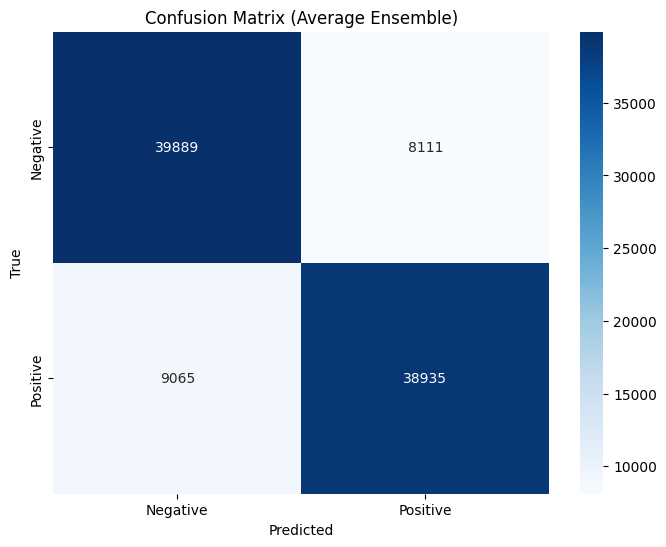

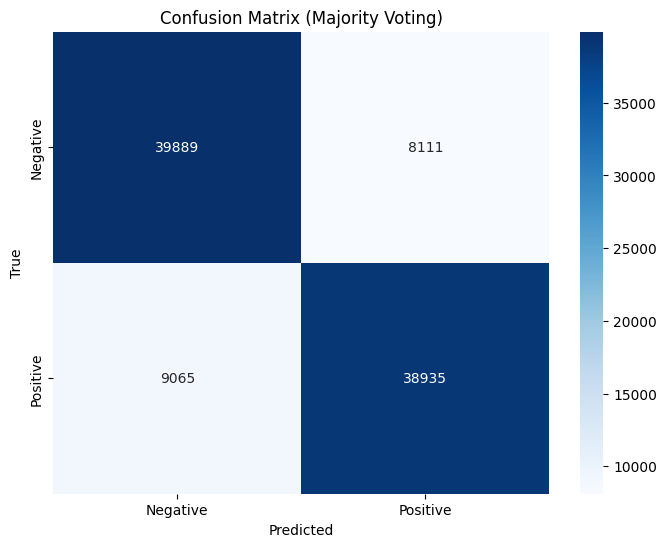

In [7]:
# prompt: visualise the above both confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are already defined from the ensemble_predict function calls
# Example for the average ensemble
cm_avg = confusion_matrix(y_true, y_pred) # from the 'average' ensemble
plt.figure(figsize=(8, 6))
sns.heatmap(cm_avg, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Average Ensemble)')
plt.show()


# Example for the majority voting ensemble (replace y_true and y_pred with the correct variables from the majority voting ensemble)
y_true, y_pred = ensemble_predict(models, test_loader, 'majority')
cm_maj = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_maj, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Majority Voting)')
plt.show()
